Student name : Cloé ESCUDIER, Romain GREGOIRE, Alexis JULIEN

In [0]:
! pip install pyspark

     |▍  

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 281.3 MB 8.9 kB/s 
     |████████████████████████████████| 199 kB 12.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=9d7a8c5420ef801d78a420a1aada4dca8975c62b59b8f30746aa5512f9620e9e
  Stored in directory: /root/.cache/pip/wheels/1d/27/68/1382001655ef41217e1dd34d59aa777612135379bab64279e9
Successfully built pyspark
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import element_at,mean, col,lit,datediff, date_add,corr
from pyspark.sql.types import *
from itertools import combinations
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.window import Window 
from pyspark.ml.stat import Correlation
import numpy as np
import pyspark.context as sc
import matplotlib as mp
import os
from pyspark.sql.functions import concat

In [0]:
spark_application_name = "Big Data Project"
spark = (SparkSession.builder.appName(spark_application_name).getOrCreate())

def read_data(path, header=False, delimiter=','):
    ext = path.split('.')[-1]
    if ext == "csv":
        df_columns = [StructField("Date", TimestampType()),StructField("High", DoubleType()),StructField("Low", DoubleType()),StructField("Open", DoubleType()),StructField("Close", DoubleType()),StructField("Volume", DoubleType()),StructField("Adj Close", DoubleType()),StructField("company_name", StringType())]
        df_schema = StructType(df_columns)
        df = spark.read.schema(df_schema).csv(path, header=header, sep=delimiter)
    elif ext == 'txt':
        df = spark.read.text(path)
    elif ext == 'parquet':
        df = spark.read.parquet(path)
    else:
        df = spark.read.json(path)
    df.printSchema()
    df.show(10)
    print(df.count())
    return df

amazon = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/AMAZON.csv', True)
apple = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/APPLE.csv', True)
facebook = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/FACEBOOK.csv', True)
google = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/GOOGLE.csv', True)
microsoft = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/MICROSOFT.csv', True)
tesla = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/TESLA.csv', True)
zoom = read_data('dbfs:/FileStore/shared_uploads/alexis.julien@epita.fr/ZOOM.csv', True)

list_df = [amazon, apple, facebook, google, microsoft, tesla, zoom]

root
 |-- Date: timestamp (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- company_name: string (nullable = true)

+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|
|2017-01-05 0

In [0]:
def first_and_last_40(stock_price):
    print(f"First 40 rows of {stock_price.first().company_name} dataframe")
    print("-----------------------------------------------------------------------------------------")
    spark.createDataFrame(stock_price.head(40)).show(40)
    print(f"Last 40 rows of {stock_price.first().company_name} dataframe")
    print("-----------------------------------------------------------------------------------------")
    spark.createDataFrame(stock_price.tail(40)).show(40)

for df in list_df:
    first_and_last_40(df)

First 40 rows of AMAZON dataframe
-----------------------------------------------------------------------------------------
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500122070312|      AMAZON|
|2017-01-06 00:00:00|799.4400024414062|  778.47998046875|782.35998

In [0]:
def get_number_observations(stock_price):
    print(stock_price.count())

for df in list_df:
    get_number_observations(df)

987
987
987
987
987
987
411


In [0]:
def get_period(first, second):
    timestamp =  first.__getitem__('Date') - second.__getitem__('Date')
    return timestamp.days

for df in list_df:
    print(get_period(df.collect()[0],df.collect()[1]))

-1
-1
-1
-1
-1
-1
-4


In [0]:
def statistics(stock_price):
    stock_price.describe().show()

for df in list_df:
    statistics(df)

+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|summary|              High|               Low|             Open|             Close|           Volume|         Adj Close|company_name|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------+
|  count|               987|               987|              987|               987|              987|               987|         987|
|   mean|1762.0071216958152|1722.1011452099956|1743.433881363487|1742.9566644206718| 4509728.05775076|1742.9566644206718|        null|
| stddev| 667.2385315752688| 644.7988093382758|657.1153070927137| 655.9576061129322|2179817.628631287| 655.9576061129322|        null|
|    min|  758.760009765625| 747.7000122070312|757.9199829101562| 753.6699829101562|         881300.0| 753.6699829101562|      AMAZON|
|    max|           3552.25|  3486.68994140625|        

In [0]:
from pyspark.sql.functions import isnan, col, when, count

def missing_values(stock_price):
    cols = [c for c, typ in df.dtypes if typ not in ("timestamp", "date")]
    stock_price.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()
for df in list_df:
    missing_values(df)

+----+---+----+-----+------+---------+------------+
|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+---+----+-----+------+---------+------------+
|   0|  0|   0|    0|     0|        0|           0|
+----+---+----+-----+------+---------+------------+

+----+---+----+-----+------+---------+------------+
|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+---+----+-----+------+---------+------------+
|   0|  0|   0|    0|     0|        0|           0|
+----+---+----+-----+------+---------+------------+

+----+---+----+-----+------+---------+------------+
|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+---+----+-----+------+---------+------------+
|   0|  0|   0|    0|     0|        0|           0|
+----+---+----+-----+------+---------+------------+

+----+---+----+-----+------+---------+------------+
|High|Low|Open|Close|Volume|Adj Close|company_name|
+----+---+----+-----+------+---------+------------+
|   0|  0|   0|    0|     0|        0|           0|
+----+---

In order to have a complete correlation matrix we need to vectorize columns desired.
Then with the correlation function from pyspark we calculate each correlation value and we put them into a matrix.

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


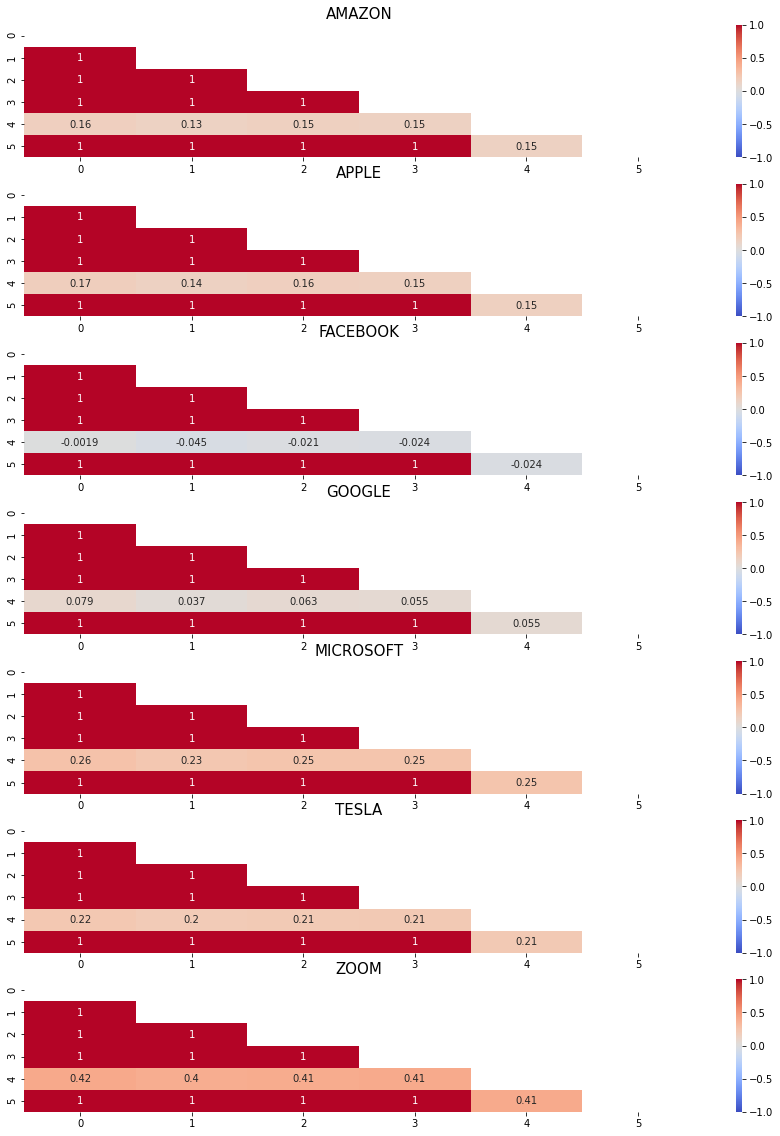

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import seaborn as sns 
import matplotlib.pyplot as plt

inputCols = [
 'High',
 'Low',
 'Open',
 'Close',
 'Volume',
 'Adj Close'
]

matrixes = []

for df in list_df:
    df2 = df.alias('df2')

    # convert to vector column first
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=inputCols, outputCol=vector_col)
    df_vector = assembler.transform(df2).select(vector_col)

    # get correlation matrix
    matrix = Correlation.corr(df_vector, vector_col)
    matrixes.append(matrix.collect()[0][matrix.columns[0]].toArray())

#
fig, axs = plt.subplots(7, 1, figsize=(15, 20))

for i in range(7):
        upp_mat = np.triu(matrixes[i])
        sns.heatmap(matrixes[i], vmin = -1, vmax = +1, annot = True,cmap = 'coolwarm', mask = upp_mat, ax=axs[i])
        axs[i].set_title(list_df[i].collect()[0][7], size = 15)


In [0]:
#Moving average
def compute_movingAverage(df, column_name, nb_points):
    window = Window.orderBy(col('Date').cast('timestamp').cast('long')).rangeBetween(-(nb_points*86400) - 1, 0)
    df_copy = df.select('*')
    df_copy = df_copy.select(col('*'),mean(column_name).over(window).alias('Moving_average'))
    return df_copy
        
list_df_MA = []
for elt in list_df:
    df_move = compute_movingAverage(elt, 'High',7)
    list_df_MA.append(df_move)
    first_and_last_40(df_move)

First 40 rows of AMAZON dataframe
-----------------------------------------------------------------------------------------
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+-----------------+
|               Date|             High|              Low|             Open|            Close|   Volume|        Adj Close|company_name|   Moving_average|
+-------------------+-----------------+-----------------+-----------------+-----------------+---------+-----------------+------------+-----------------+
|2017-01-03 00:00:00| 758.760009765625|747.7000122070312|757.9199829101562|753.6699829101562|3521100.0|753.6699829101562|      AMAZON| 758.760009765625|
|2017-01-04 00:00:00|759.6799926757812|754.2000122070312|758.3900146484375|757.1799926757812|2510500.0|757.1799926757812|      AMAZON|759.2200012207031|
|2017-01-05 00:00:00|782.4000244140625| 760.260009765625|761.5499877929688|780.4500122070312|5830100.0|780.4500

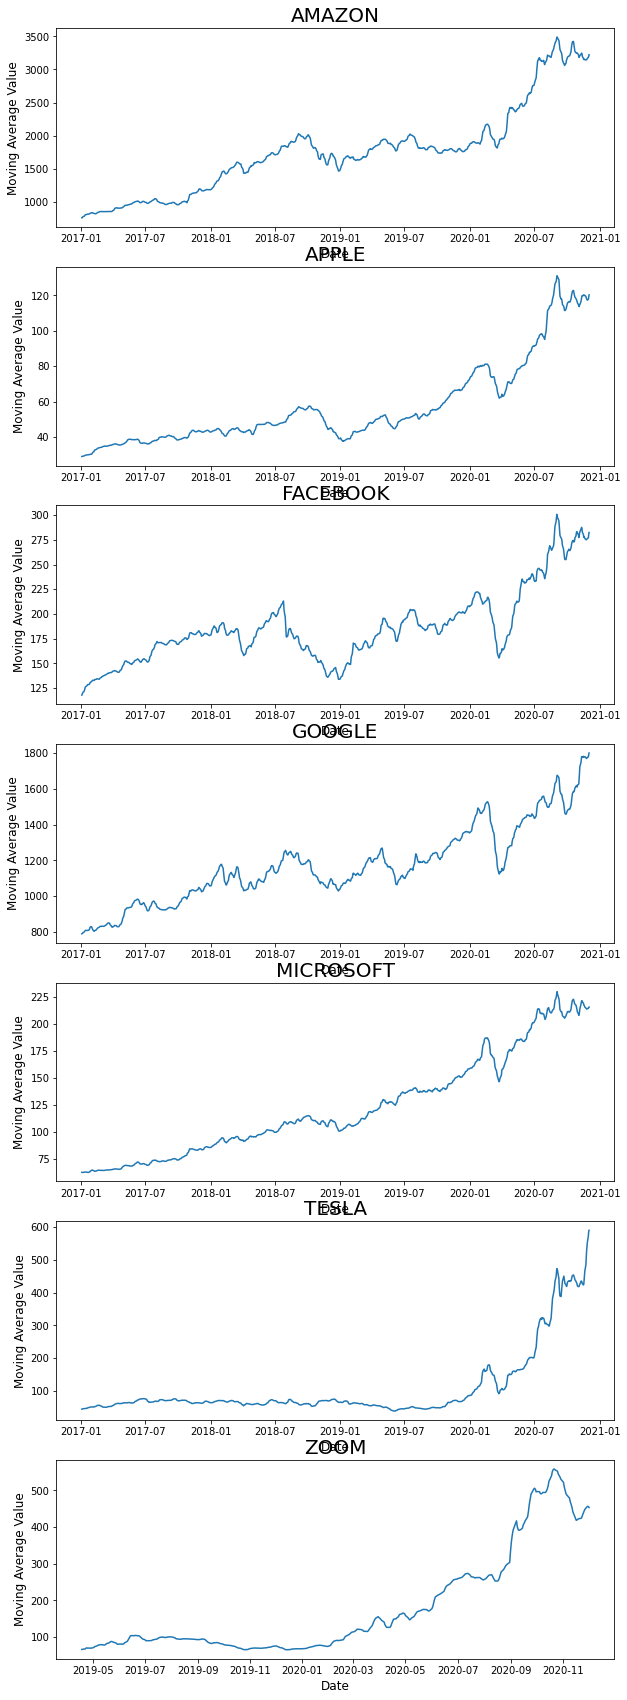

In [0]:
fig, axs = plt.subplots(7, 1, figsize=(10, 30))

for i in range(7):
    axs[i].set_title(list_df_MA[i].collect()[0][7], size = 20)
    axs[i].set_xlabel("Date", size = 12,)
    axs[i].set_ylabel("Moving Average Value", size = 12)
    axs[i].plot(list_df_MA[i].select("Date").collect(), list_df_MA[i].select("Moving_average").collect())


In [0]:
list_df[0].dtypes

Out[12]: [('Date', 'timestamp'),
 ('High', 'double'),
 ('Low', 'double'),
 ('Open', 'double'),
 ('Close', 'double'),
 ('Volume', 'double'),
 ('Adj Close', 'double'),
 ('company_name', 'string')]

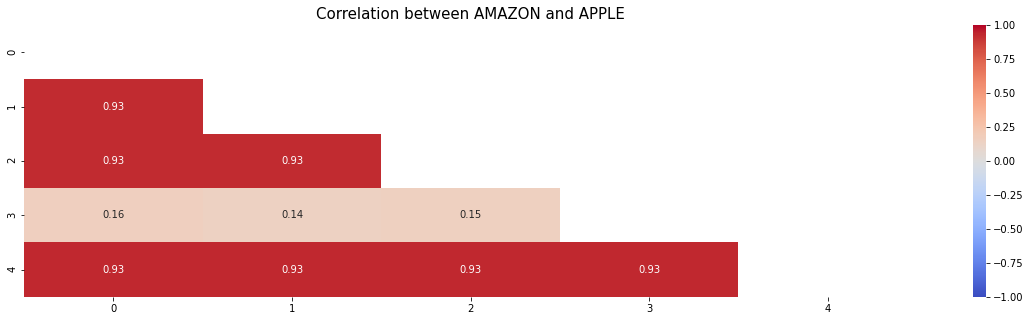

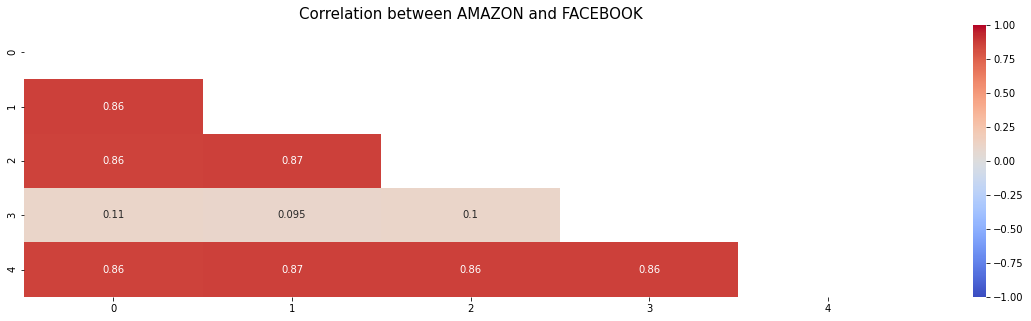

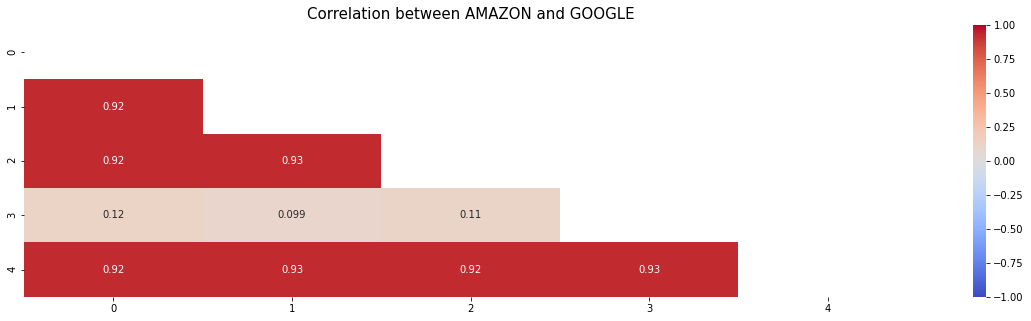

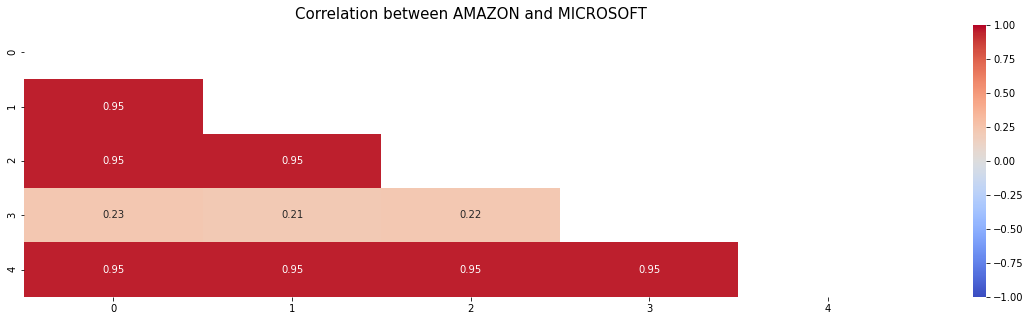

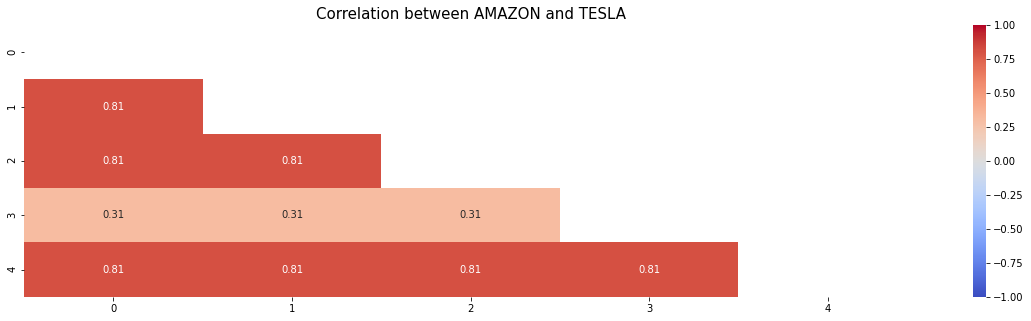

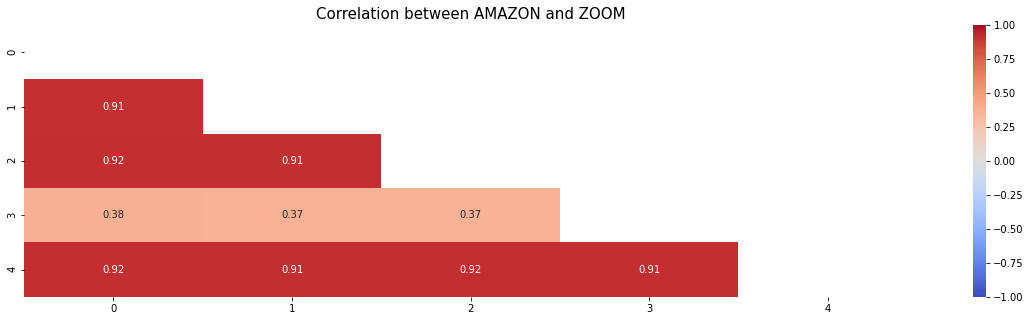

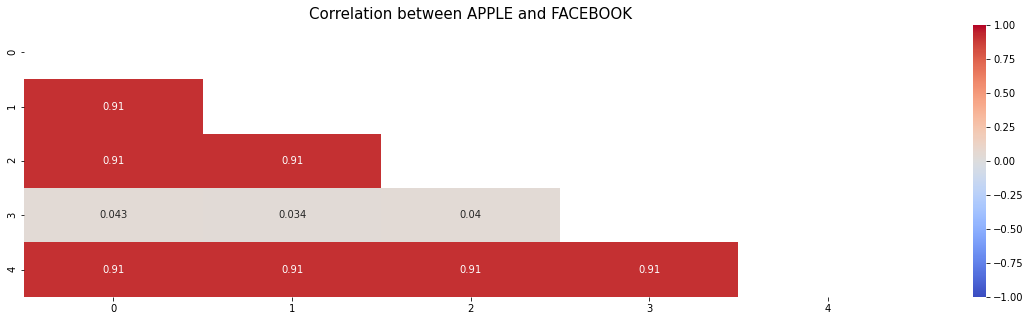

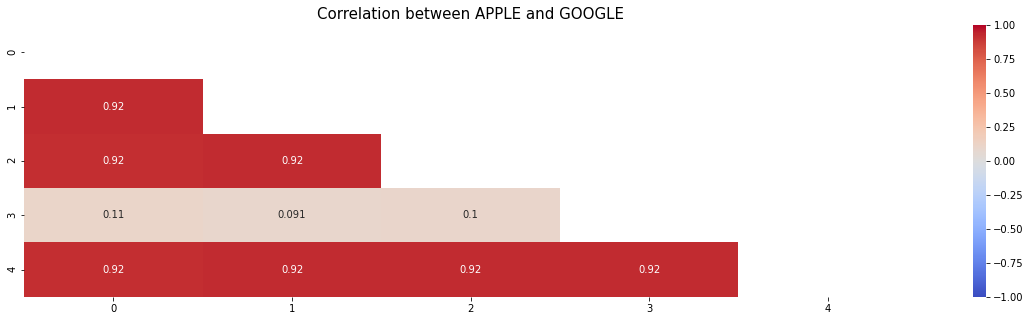

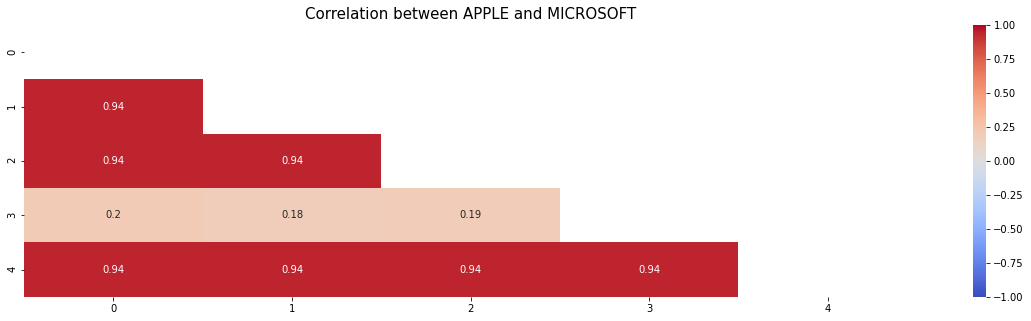

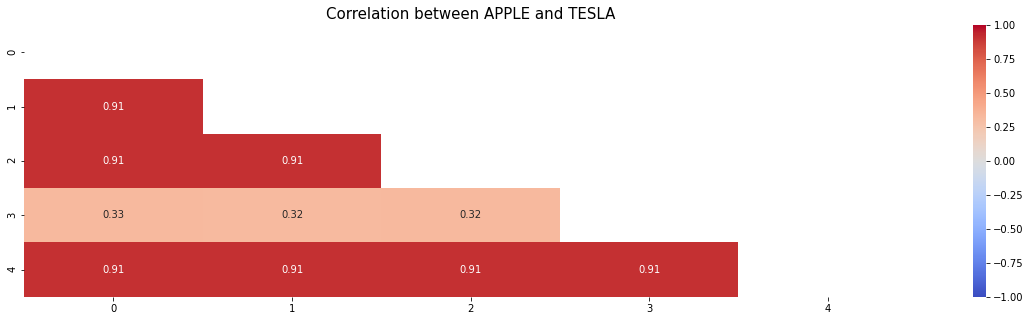

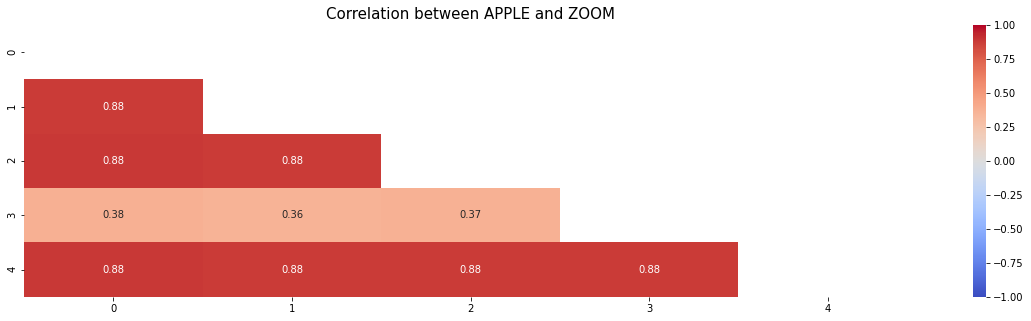

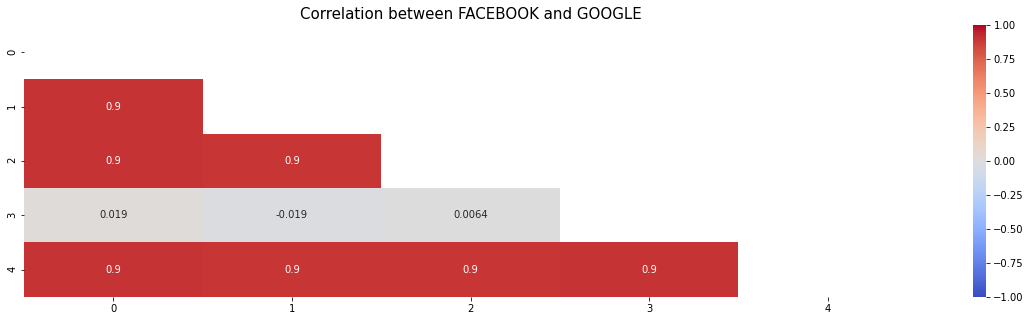

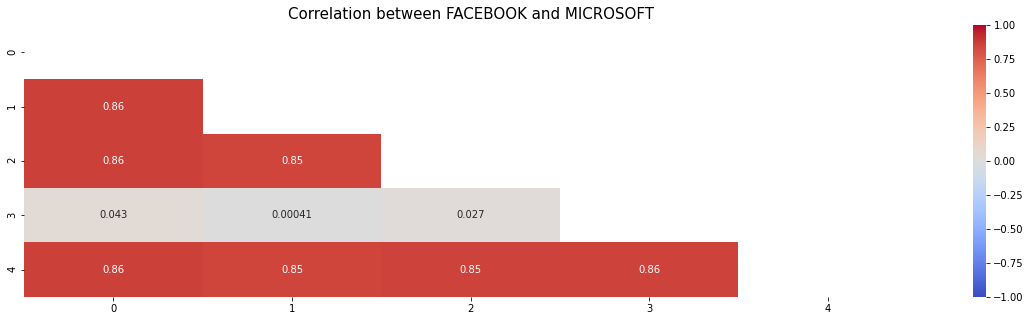

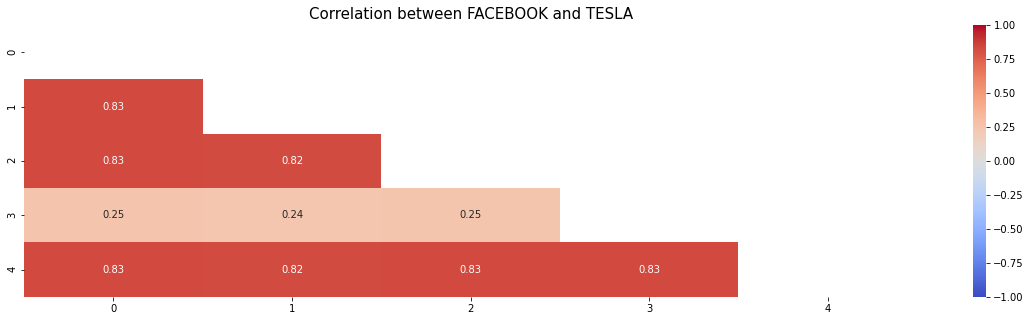

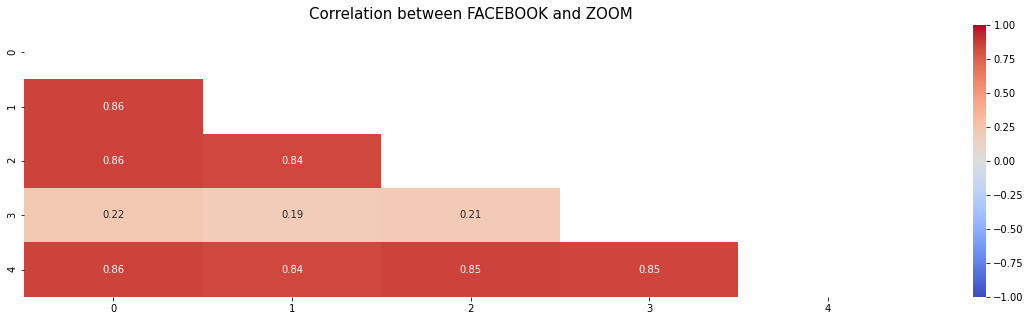

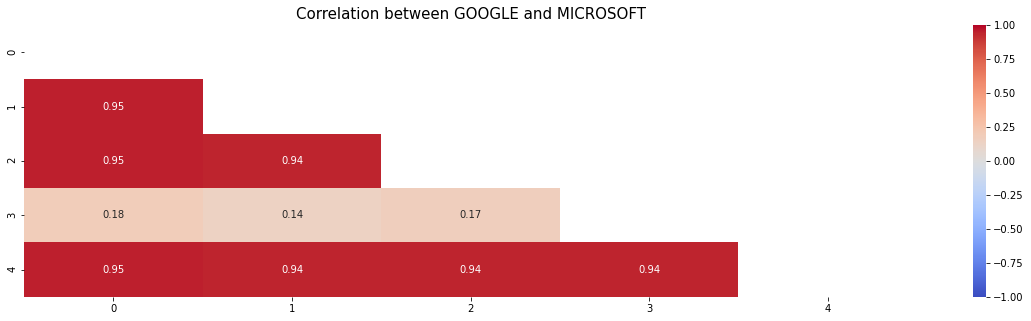

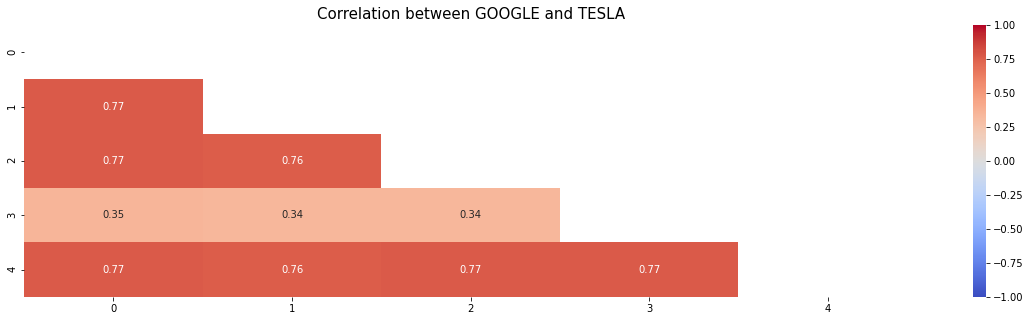

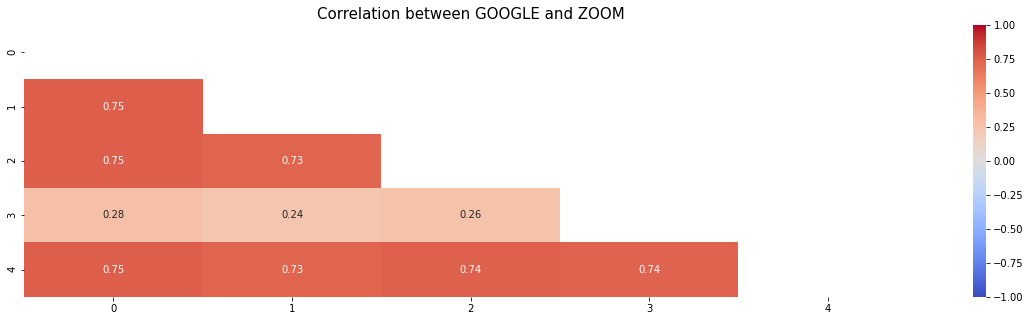

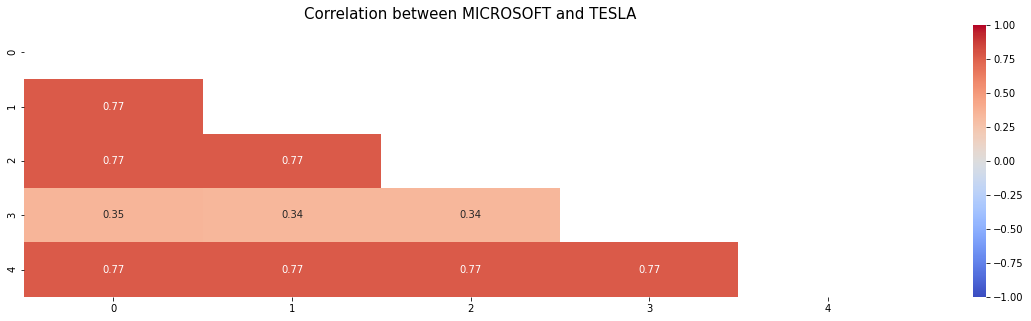

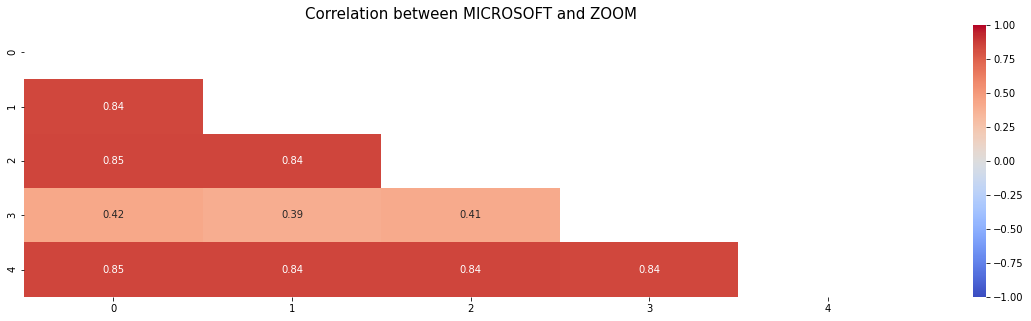

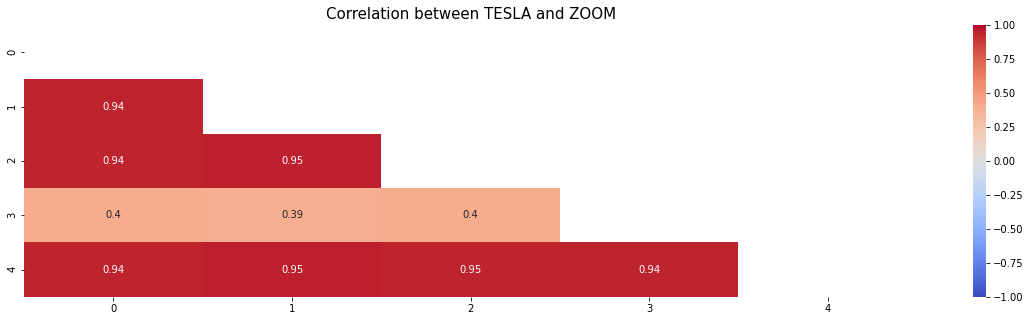

In [0]:
def corelation_stocks_columns(df1, df2, column_name1,column_name2):

    df1 = df1.select(*(col(x).alias(x + '_df1') for x in df1.columns))
    df2 = df2.select(*(col(x).alias(x + '_df2') for x in df2.columns))

    df = df1.join(df2, df1['Date_df1'] == df2['Date_df2'], how="inner")

    list1 = df.select(column_name1+'_df1').rdd.flatMap(lambda x: x).collect()
    list2 = df.select(column_name2+'_df2').rdd.flatMap(lambda x: x).collect()

    column1_name = df1.select('company_name_df1').rdd.flatMap(lambda x: x).collect()[0]
    column2_name = df2.select('company_name_df2').rdd.flatMap(lambda x: x).collect()[0]
    
    typeval1 = df1.schema[column_name1+'_df1'].dataType
    typeval2 = df2.schema[column_name2+'_df2'].dataType

    schema = StructType([StructField(column_name1 + ' ' + column1_name,typeval1,True),\
    StructField(column_name2 + ' ' + column2_name,typeval2,True)])

    dfFromData2 = spark.createDataFrame(zip(list1, list2), schema)
    return dfFromData2.stat.corr(dfFromData2.dtypes[0][0], dfFromData2.dtypes[1][0])

def correlation_between_all_df(list_df):
    listdf2 = [df.alias('copy_df') for df in list_df]
    for elem in combinations(listdf2, 2):
        coeff_corr = []
        list_columns = [subelem[0] for subelem in elem[0].dtypes]
        for column_names in combinations(list_columns, 2):
            if((column_names[0] != "company_name" and column_names[1] != "company_name") and (column_names[0] != "Date" and column_names[1] != "Date")):
                corr_value = corelation_stocks_columns(elem[0], elem[1], column_names[0], column_names[1])
                sub_coeff_corr = [column_names[0], column_names[1], corr_value]
                coeff_corr.append(corr_value)
        matrix = np.zeros((5,5))
        inds = np.triu_indices_from(matrix, k = 0)
        matrix[inds] = coeff_corr[:]
        matrix[(inds[1], inds[0])] = coeff_corr[:]
        fig, ax = plt.subplots(figsize=(20, 5))
        upp_mat = np.triu(matrix)
        company1 = elem[0].select('company_name').rdd.flatMap(lambda x: x).collect()[0]
        company2 = elem[1].select('company_name').rdd.flatMap(lambda x: x).collect()[0]
        ax = sns.heatmap(matrix, vmin = -1, vmax = +1, annot = True,cmap = 'coolwarm', mask = upp_mat)
        ax.set_title('Correlation between '+ company1 + ' and ' + company2, size = 15)
        plt.show()


correlation_between_all_df(list_df)

In [0]:

def rate_of_return(stock, first_date, period):
    if period == 'week':
        new_stock = stock.withColumn('last_date', F.date_add(stock['Date'], 7))
    elif period == 'month':
        new_stock = stock.withColumn('last_date', F.add_months(stock['Date'], 1))
    elif period == 'year':
        new_stock = stock.withColumn('last_date', F.date_add(stock['Date'], 365))
    else:
        new_stock = stock.withColumn('last_date', F.date_add(stock['Date'], 1))
    first_row = new_stock.filter(new_stock['Date'] == first_date).first()
    if not first_row:
        return -1
    initial_value = first_row['Adj Close']
    last_value = new_stock.filter(new_stock['Date'] == first_row['last_date']).first()['Adj Close']
    rate = ((last_value - initial_value) / initial_value) * 100
    return rate

print(rate_of_return(amazon, "2017-01-03 00:00:00", "year"))

def best_rate(first_date, period):
    max = rate_of_return(list_df[0], first_date, period)
    best_df = list_df[0]
    for df in list_df[1:]:
        rate = rate_of_return(df, first_date, period)
        if rate > max:
            max = rate
            best_df = df
    return best_df

best_rate("2017-01-03 00:00:00", "week").show()

59.77814938603249
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|               Date|              High|               Low|              Open|             Close|   Volume|         Adj Close|company_name|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------+
|2017-01-03 00:00:00|117.83999633789062|115.51000213623047|116.02999877929688|116.86000061035156|2.06639E7|116.86000061035156|    FACEBOOK|
|2017-01-04 00:00:00|119.66000366210938|117.29000091552734|117.55000305175781|118.69000244140625|1.96309E7|118.69000244140625|    FACEBOOK|
|2017-01-05 00:00:00|120.94999694824219|118.31999969482422|118.86000061035156|120.66999816894531|1.94922E7|120.66999816894531|    FACEBOOK|
|2017-01-06 00:00:00|123.87999725341797|120.02999877929688| 120.9800033569336|123.41000366210938|2.85453E7|123.41000366210938|    FACEBOOK|
|2

# Insights :

### Bande de Bolliger :

Les bandes de Bollinger sont un outil d'analyse économique développé par John Bollinger. Elles sont utilisées en finance de marché pour des analyses techniques et permettent d'évaluer la volatilité et l'évolution probable de prix ou d'indices. 
La largeur de la bande est une indication directe de la volatilité sur l'actif considéré. Théoriquement, il y a plus de 95 % de chance que l'évolution de la valeur s'établisse dans le cadre des bandes réglées avec une distance de deux écarts-types. Une volatilité faible est suivie d'une volatilité forte et inversement une volatilité forte est suivie d'une volatilité faible. De ce fait lorsque l'écartement des bandes de Bollinger est faible, il est suivi d'un écartement fort donc d'une forte volatilité des cours. Ceux-ci partent alors à la hausse comme à la baisse avec une pente variable.

### Oscillateur d'Aroon :

L’oscillateur Aroon peut générer des signaux commerciaux ou donner un aperçu de la direction de la tendance actuelle d’un actif.

Lorsque l’oscillateur se déplace au-dessus de la ligne zéro, cela signifie que l’Aroon Up passe au-dessus de l’Aroon Down. Cela signifie que le prix a atteint un sommet plus récemment qu’un creux. Cela pourrait être un signe qu’une tendance haussière commence.

Lorsque l’oscillateur passe en dessous de zéro, cela signifie que l’Aroon Down passe en dessous de l’Aroon Up. Un plus bas s’est produit plus récemment qu’un plus haut, ce qui pourrait signaler le début d’une tendance à la baisse.

Oscillateur Aroon = Aroon Up − Aroon down

### Theorie de Markowitz :

La théorie moderne du portefeuille, développée par Harry Markowitz dans les années 1950, définit le processus de sélection de titres pour créer le portefeuille le plus efficient possible, c'est à dire qui possède la rentabilité maximum pour un niveau de risque minimum.

Le concept dediversification est à la base de la théorie. En effet, Markowitz pense que les différents titres composant un portefeuille ne peuvent être sélectionnés individuellement et doivent au contraire être choisi selon la corrélation de leurs variations à celles du reste des actifs du portefeuille.

Ce mode de sélection permet de minimiser le risque pour un niveau de rendement choisi.

Analysons les différents composants du modèle :

Makowitz présuppose que les investisseurs sont rationnels et averses au risque et que le marché est efficient. Ainsi, les seuls éléments à prendre en compte sont le risque et le rendement des titres, car les investisseurs achèteront toujours l'actif qui présente un rendement optimal par rapport à son niveau de risque. Aucun investisseur purement rationnel n'achèterait en effet un actif A plus risqué qu'un actif B mais offrant un rendement inférieur.

### Principe de diversification :

La diversification d’un portefeuille boursier consiste à répartir ses investissements sur plusieurs titres ou lignes au sein de son compte-titres ordinaire ou de son plan d’épargne en actions (PEA), pour :

 - diluer le risque de perte lié à chacun d’entre eux
 - se positionner sur plusieurs opportunités simultanément
 - s’exposer à différents facteurs d’appréciation des cours de Bourse
La diversification est la traduction concrète en Bourse de l’adage selon lequel on ne doit pas mettre tous ses œufs dans le même panier.

### Methode de Monte Carlo :

On appelle méthode de Monte-Carlo toute méthode visant à calculer une valeur numérique, et utilisant des procédés aléatoires, c'est-à-dire des techniques probabilistes. Le nom de ces méthodes fait allusion aux jeux de hasard pratiqués à Monte-Carlo.

Les méthodes de Monte-Carlo sont particulièrement utilisées pour calculer des intégrales en dimensions plus grandes que 1 (en particulier, pour calculer des surfaces, des volumes, etc.)

La méthode de simulation de Monte-Carlo permet aussi d'introduire une approche statistique du risque dans une décision financière. Elle consiste à isoler un certain nombre de variables-clés du projet telles que le chiffre d'affaires ou la marge... et à leur affecter une distribution de probabilités. Pour chacun de ces facteurs, on effectue un grand nombre de tirages aléatoires dans les distributions de probabilité déterminées précédemment, afin de déterminer la probabilité d'occurrence de chacun des résultats.

### L'étoile du soir
L'étoile du soir est une figure chartiste en chandelier japonais. Selon l'étude réalisée par Thomas Bulkowski dans le cadre de son ouvrage Encyclopedia of Candlestick Charts, l'étoile du soir fait partie des 5 figures en chandelier japonais les plus efficaces, avec près de 72% de réussite.  

Elle est composée de trois bougies distinctes :

 - une première bougie haussière disposant d'un grand corps,
 - une seconde bougie généralement baissière (mais pas obligatoirement) formant un gap haussier (son plu bas est supérieur au plus haut de la première bougie), 
 - une troisième bougie baissière disposant d'un grand corps.

L'étoile du soir annonce un retournement de sommet, c'est-à-dire un retournement de tendance à la baisse, et donc un fort signal de vente. 

### Le RSI
  Le RSI, ou Relative Strength Index, est un indicateur technique très populaire mettant en évidence les tendances fortes du marché. Sa valeur est strictement comprise entre 0 et 100, et il indique les phases de surachat, les phases neutres et les phases de survente d'un actif financier sur une période de temps prédéterminée.  Ainsi, lorsque le RSI dépasse la valeur 70, le marché se trouve en situation d'euphorie à l'achat. Il s'agit d'un signal de vente fort, utilisé par de nombreux investisseurs pour quitter une position à l'achat ou pour se positionner à la vente.  

### Le Parabolique S.A.R
Le SAR parabolique (parabolique stop and reverse) est l'un des indicateurs de suivi de tendance les plus populaires. Son intérêt réside dans le fait qu'il n'est pas seulement utile en cas d'arrêt et de retournement de la tendance. Le SAR parabolique a été développé par J. Welles Wilder Jr. et, lorsqu'il est tracé sur un graphique, il print des paraboles (points) qui suivent l'action du prix en conséquence. Une parabole haussière est print en dessous du prix lorsque la tendance est à la hausse, tandis qu'une parabole baissière est print au-dessus du prix lorsque la tendance est à la baisse.

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [0]:
amazon_complete = amazon.alias('amazon_complete')

amazon_complete = amazon_complete.withColumn("Open-Close",col("Open") - col("Close"))
amazon_complete = amazon_complete.withColumn("High-Low",col("High") - col("Low"))

y = []
for rows in amazon_complete.collect():
    if rows['Open-Close'] > 0:
        y.append(1)
    else:
        y.append(0)

y_df = spark.createDataFrame(y, IntegerType())  

amazon_complete = amazon_complete.withColumn("label", 
   when((amazon_complete['Open-Close'] > 0), lit(1)) 
     
     .otherwise(lit(0)) \
  )


On crée un modèle de régression linéaire sur notre table de données Amazon. On se sert des données OPEN, HIGH, LOW et VOLUME pour calculer notre formule. Et on peut ensuite comparer nos predictions avec les valeurs réelles de close.

The formula for the linear regression line is
price = -0.61*open + -0.07
+-----------------+--------------------+-----------------+-----------------+
|             open|            features|            close|       prediction|
+-----------------+--------------------+-----------------+-----------------+
|761.5499877929688|[761.549987792968...|780.4500122070312|779.4227254951362|
|793.6599731445312|[793.659973144531...|  799.02001953125|796.3013173319798|
|814.3200073242188|[814.320007324218...|817.1400146484375|819.4847748300697|
|806.7999877929688|[806.799987792968...|817.8800048828125|815.9712420412153|
|           823.75|[823.75,826.98999...|  823.47998046875| 824.402903808017|
|809.7999877929688|[809.799987792968...|807.6400146484375|806.7630577001472|
|            837.0|[837.0,838.309997...|836.3900146484375|834.8788023431393|
|857.5700073242188|[857.570007324218...|852.1900024414062|853.9187128391702|
|            851.0|[851.0,856.400024...|            853.0|855.8350384203459|
|  

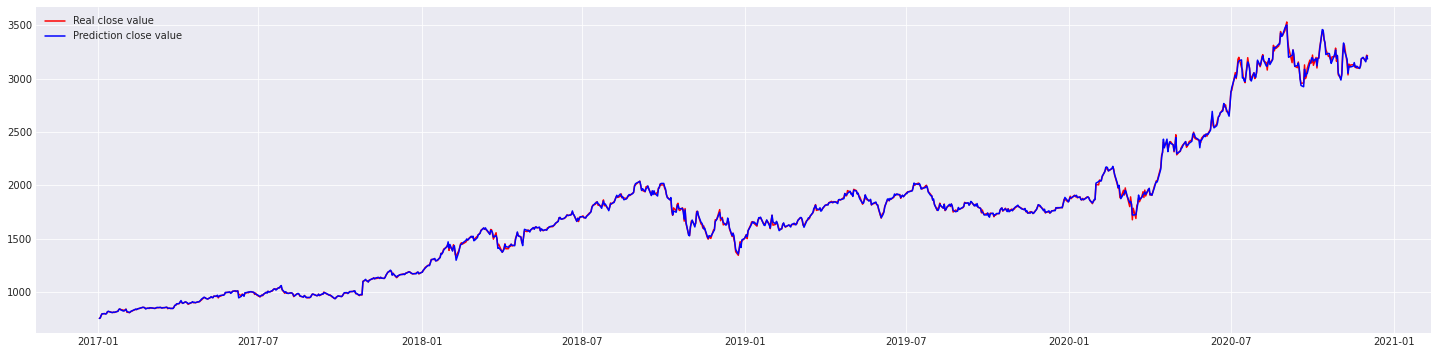

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

trainDF, testDF = amazon_complete.randomSplit([.8, .2], seed=42)

vecAssembler = VectorAssembler(inputCols=['Open', 'High', 'Low', 'Volume'], outputCol="features")
vecTrainDF = vecAssembler.transform(trainDF)

lr = LinearRegression(featuresCol="features", labelCol="Close")
lrModel = lr.fit(vecTrainDF)

m = round(lrModel.coefficients[0], 2)
b = round(lrModel.intercept, 2)
print(f"""The formula for the linear regression line is
price = {m}*open + {b}""")

pipeline = Pipeline(stages=[vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)

predDF = pipelineModel.transform(testDF)
predDF.select("open", "features", "close", "prediction").show(10)

showDF = pipelineModel.transform(amazon_complete)

regressionEvaluator = RegressionEvaluator(
predictionCol="prediction",
labelCol="Close",
metricName="rmse")

r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"R2 is {r2}")

f = plt.figure()
f.set_figwidth(25)
f.set_figheight(6)

date = amazon.select('Date').collect()
close = amazon.select('close').collect()
predicted_close = showDF.select('prediction').collect()

plt.plot(date, close,color='red', label="Real close value")
plt.plot(date, predicted_close,color='blue', label="Prediction close value")
plt.legend()

On a ensuite décidé de pousser les choses un peu plus loin en essayant de créer un modèle qui nous permettrait de savoir quand acheté l'action pour pouvoir la revendre le soir même et faire du profit. On a donc comme une résultat une colonne avec un 1 s'il faut acheter et un 0 sinon.

In [0]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import confusion_matrix

vecAssembler = VectorAssembler(inputCols=['Open', 'High', 'Low', 'Volume'], outputCol="features")
va_df = vecAssembler.transform(amazon_complete)
va_df_fin = va_df.select(['Open-Close','features', 'label'])

Columns = ['Open-Close','features', 'label']
train = spark.createDataFrame(data=va_df_fin.head(100), schema = Columns)
test = spark.createDataFrame(data=va_df_fin.tail(800), schema = Columns)

lsvc = LinearSVC(labelCol="label", maxIter=50)
lsvc = lsvc.fit(train)

pred = lsvc.transform(test)
pred.show(20)


+------------------+--------------------+-----+--------------------+----------+
|        Open-Close|            features|label|       rawPrediction|prediction|
+------------------+--------------------+-----+--------------------+----------+
|   -1.239990234375|[960.109985351562...|    0|[0.36390455078363...|       0.0|
|  4.80999755859375|[964.0,967.309997...|    1|[-1.1919722057465...|       1.0|
|   0.9000244140625|[958.0,963.690002...|    1|[-0.2731126402313...|       1.0|
|  -11.239990234375|[954.210021972656...|    0|[1.62865894213085...|       0.0|
| -10.8499755859375|[970.0,981.510009...|    0|[1.58688067167743...|       0.0|
|-13.94000244140625|[975.640014648437...|    0|[2.84691118603099...|       0.0|
|              2.25|[993.239990234375...|    1|[0.04747974151313...|       0.0|
|    9.469970703125|[996.669982910156...|    1|[-1.8320130682867...|       1.0|
|    -3.72998046875|[991.27001953125,...|    0|[-0.1088912017989...|       1.0|
|  -4.1199951171875|[996.809997558593...

Notre modèle a un taux de 83% de bonne prédiction

In [0]:
evaluator=MulticlassClassificationEvaluator(metricName="accuracy")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)

y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm) 

Prediction Accuracy:  0.835
Confusion Matrix:
[[374  29]
 [103 294]]


On peut donc vérifier si notre modèle est rentable en le comparant à la meilleure stratégie possible c'est à dire : acheter uniquement quand on sait que le prix va monter.

Out[29]: <matplotlib.legend.Legend at 0x7fe2fe42b970>

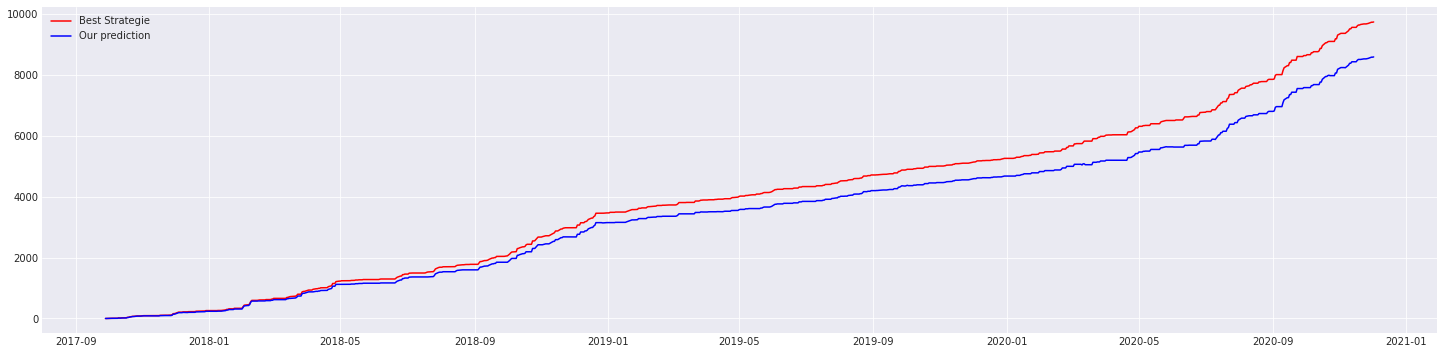

In [0]:
s, s1 = 0, 0
sum, sum1 = [0],[0]
for rows in pred.collect():
    if rows['Open-Close'] > 0 and rows['prediction'] == 1.0:
        s += rows['Open-Close']
        s1 += rows['Open-Close']
        sum.append(s)
        sum1.append(s1)
    elif rows['Open-Close'] > 0 and rows['prediction'] == 0.0:
        s += rows['Open-Close']
        s1 += 0
        sum.append(s)
        sum1.append(s1)
    elif rows['Open-Close'] < 0 and rows['prediction'] == 1.0:
        s += 0
        s1 += rows['Open-Close']
        sum.append(s)
        sum1.append(s1)
    else:
        s += 0
        s1 += 0
        sum.append(s)
        sum1.append(s1)
        
import matplotlib.pyplot as plt
%matplotlib inline

date = amazon.select('Date').collect()[-801:]

f = plt.figure()
f.set_figwidth(25)
f.set_figheight(6)

plt.plot(date, sum,color='red', label="Best Strategie")
plt.plot(date, sum1,color='blue', label="Our prediction")
plt.legend()